In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

# Part 1

## Load data

In [3]:
S1= pd.read_csv("Stations\S1flow.txt", header=None, delim_whitespace=True)  # Change le délimiteur si besoin delim_whitespace=True
S2= pd.read_csv("Stations\S2flow.txt", sep=('  '), header=None)  # Change le délimiteur si besoin
S2=S2.transpose()

<>:1: SyntaxWarning: invalid escape sequence '\S'
<>:2: SyntaxWarning: invalid escape sequence '\S'
<>:1: SyntaxWarning: invalid escape sequence '\S'
<>:2: SyntaxWarning: invalid escape sequence '\S'
C:\Users\moeag\AppData\Local\Temp\ipykernel_19060\1182934203.py:1: SyntaxWarning: invalid escape sequence '\S'
  S1= pd.read_csv("Stations\S1flow.txt", header=None, delim_whitespace=True)  # Change le délimiteur si besoin delim_whitespace=True
C:\Users\moeag\AppData\Local\Temp\ipykernel_19060\1182934203.py:2: SyntaxWarning: invalid escape sequence '\S'
  S2= pd.read_csv("Stations\S2flow.txt", sep=('  '), header=None)  # Change le délimiteur si besoin
C:\Users\moeag\AppData\Local\Temp\ipykernel_19060\1182934203.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  S1= pd.read_csv("Stations\S1flow.txt", header=None, delim_whitespace=True)  # Change le délimiteur si besoin delim_whitespace=True
C:\

           0
0   1.727905
1   5.281199
2   8.754718
3  21.166835
4  34.468974


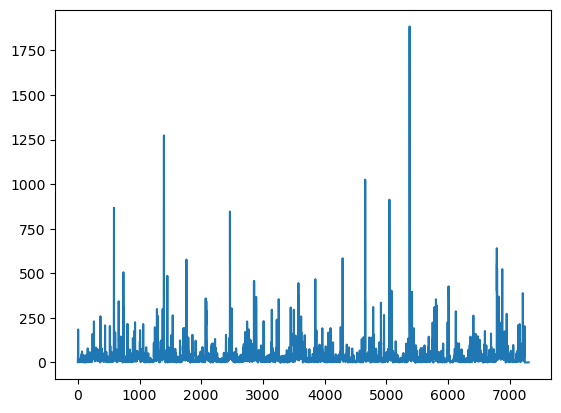

In [4]:
print(S2.head())
plt.plot(S2)

In [5]:
print(S1.shape)
print(S2.shape)

(2195, 1)
(7305, 1)


In [6]:
# Création des index temporels pour chaque série
start_date_S1 = pd.to_datetime('2016-12-28')  # Date de début 
start_date_S2 = pd.to_datetime('2003-01-01')  

S1.index = pd.date_range(start=start_date_S1, periods=len(S1), freq='D')
S2.index = pd.date_range(start=start_date_S2, periods=len(S2), freq='D')

S1.columns = ['Q1']
S2.columns = ['Q2']

In [7]:
S1.head()

,Q1
2016-12-28,106.870920
2016-12-29,139.441930
2016-12-30,61.254229
2016-12-31,56.156909
2017-01-01,80.952344


## a) polynomial function for the common years between S1 and S2

<>:25: SyntaxWarning: invalid escape sequence '\p'
<>:25: SyntaxWarning: invalid escape sequence '\p'
C:\Users\moeag\AppData\Local\Temp\ipykernel_19060\2981902021.py:25: SyntaxWarning: invalid escape sequence '\p'
  plt.savefig("data_P1\pol_adj.pdf", format='pdf')


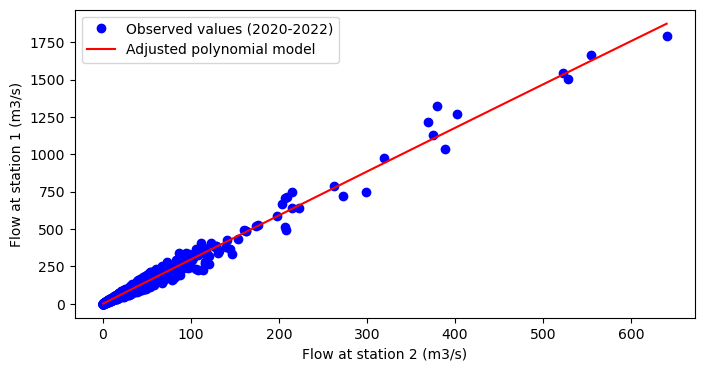

In [19]:
# Extraire les deux dernières années (2020–2022) des séries S1 et S2
start_date = pd.to_datetime('2020-01-01')
end_date = pd.to_datetime('2022-12-31')
S1_recent = S1[(S1.index >= start_date) & (S1.index <= end_date)]
S2_recent = S2[(S2.index >= start_date) & (S2.index <= end_date)]

# Ajustement polynômial de S1 en fonction de S2 (degré 2)
degree = 2
coefficients = np.polyfit(S2_recent['Q2'], S1_recent['Q1'], deg=degree)
polynomial_model = np.poly1d(coefficients)

# Valeurs modélisées (en fonction du modèle polynomiale ajusté)
S2_values = np.linspace(S2_recent['Q2'].min(), S2_recent['Q2'].max(), 100)
S1_values = polynomial_model(S2_values)

# Visualisation de la fonction polynomiale ajustée
plt.figure(figsize=(8, 4))
plt.plot(S2_recent['Q2'], S1_recent['Q1'], label='Observed values (2020-2022)', color='blue', marker='o', linestyle='None')
plt.plot(S2_values, S1_values, label='Adjusted polynomial model', color='red', linestyle='-')
plt.xlabel('Flow at station 2 (m3/s)')
plt.ylabel('Flow at station 1 (m3/s)')
#plt.title('Polynomial adjustement between Q1 and Q2')
plt.legend()
#plt.grid(True)
plt.savefig("data_P1\pol_adj.pdf", format='pdf')
plt.show()



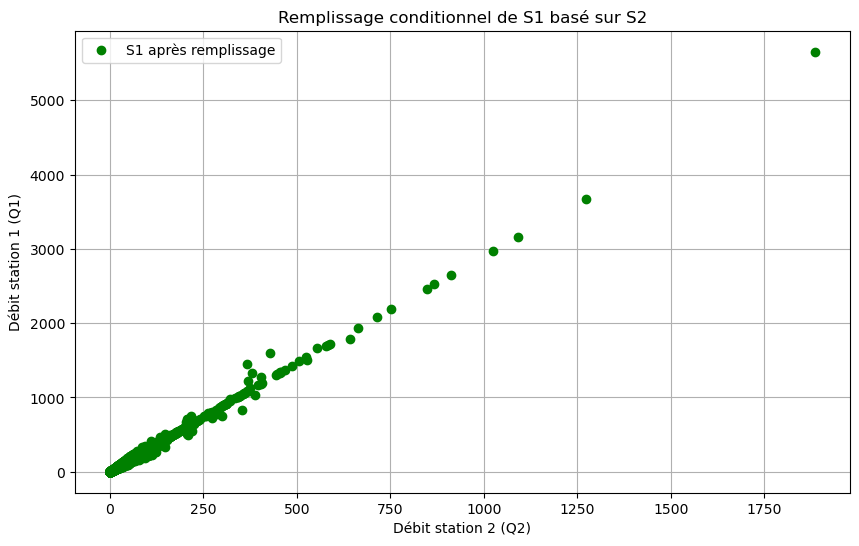

In [14]:
## Replacing missing data
# Fusion des deux séries pour assurer l'alignement temporel
S1S2 = pd.concat([S1['Q1'], S2['Q2']], axis=1)

S1_full = pd.DataFrame(index=S2.index)

S1_estimated = polynomial_model(S1S2['Q2'])

# Remplissage conditionnel : si S1 est NaN ou 0, on utilise la valeur estimée ; sinon on garde la valeur existante
S1_full['Q1'] = np.where((S1S2['Q1'].isna()) | (S1S2['Q1'] == 0),    S1_estimated,    S1S2['Q1'])

# Modifier le ds fusionné
S1S2['Q1']=S1_full['Q1']

#graphe
plt.figure(figsize=(10, 6))
#plt.plot(S2_recent['Q2'], S1_recent['Q1'], 'o', label='Observations S1 originales', alpha=0.5)
plt.plot(S2['Q2'], S1_full['Q1'], 'o',label='S1 après remplissage', color='green')
plt.xlabel('Débit station 2 (Q2)')
plt.ylabel('Débit station 1 (Q1)')
plt.title('Remplissage conditionnel de S1 basé sur S2')
plt.legend()
plt.grid(True)
plt.show()

<>:5: SyntaxWarning: invalid escape sequence '\Q'
<>:5: SyntaxWarning: invalid escape sequence '\Q'
C:\Users\moeag\AppData\Local\Temp\ipykernel_19060\2574713409.py:5: SyntaxWarning: invalid escape sequence '\Q'
  plt.savefig("data_P1\Q1_20y.pdf", format='pdf')


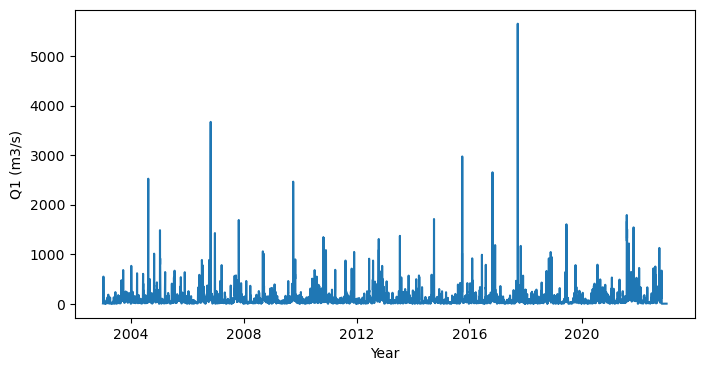

In [20]:
plt.figure(figsize=(8, 4))
plt.plot(S1_full)
plt.xlabel('Year')
plt.ylabel('Q1 (m3/s)')
plt.savefig("data_P1\Q1_20y.pdf", format='pdf')

## b) Swapping technique to have 30 years of data

Partie 7/2 slide 15 du cours:

Reshuffling by swapping data.The conditions:
- no lower frequency trends,
- long enough time series
- preserve serial correlation
- swap cycles

A faire:
1) Extract hydrological years (defined by maxima of Q)
2) Check for serial correlation (to know if the Q are correlated between years)
3) Use the swapping technique:selecting the years that allow to respect the serial correlation (conserver localement une autocorrélation proche de la série d'origine)
4) build the 10 years

In [21]:
# 1) Calcul des maxima annuels de S1
S1_full['Year'] = S1_full.index.year
S1_max_annual = S1_full.groupby('Year')['Q1'].max()

#2) Corrélation temporelle des maximas annuels
autocorr1 = S1_max_annual.autocorr(lag=1)  # Corrélation à 1 an de retard
print(f'Autocorrélation des maxima annuels à 1 an de retard: {autocorr1}')
autocorr2=S1_max_annual.autocorr(lag=2)
print(f'Autocorrélation des maxima annuels à 2 an de retard: {autocorr2}')


Autocorrélation des maxima annuels à 1 an de retard: -0.01509877053705984
Autocorrélation des maxima annuels à 2 an de retard: 0.1729042610535477


<Figure size 800x600 with 0 Axes>

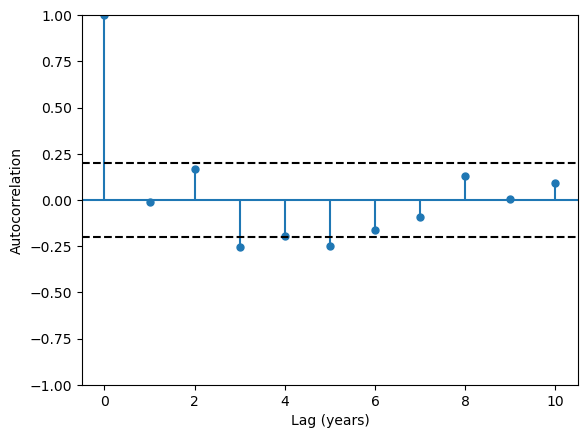

In [48]:
from statsmodels.graphics.tsaplots import plot_acf
plt.figure (figsize=(8, 6))
plot_acf(S1_max_annual, alpha=None)
plt.axhline(y=0.2, color='black', linestyle='--')
plt.axhline(y=-0.2, color='black', linestyle='--')
plt.xlabel('Lag (years)')
plt.ylabel('Autocorrelation')
plt.title('')
#plt.yticks(np.arange(-1, 1.1, 0.2))
plt.savefig("data_P1\\autocorr1.pdf", format='pdf')

There is no correlation between the annual maximas at kag 1 and 2 (r<0.2). We can therefore chose the years "au hasard", because we don't have to respect a specific serial autocorrelation.

If we wanted to do something more precise, we could have choose a year, then calculate serial autocorrelation, if not good choose an other year respecting more serial autocorrelation...

Here, we just chose to classify the years in 3 categories to avoid building patterns.

<Axes: xlabel='Year'>

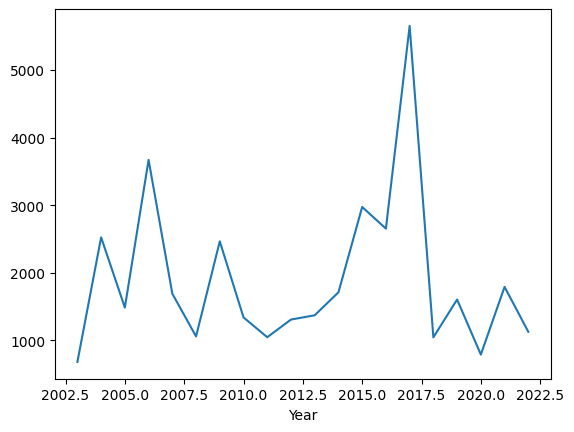

In [12]:
S1_max_annual.plot()

<>:52: SyntaxWarning: invalid escape sequence '\Q'
<>:52: SyntaxWarning: invalid escape sequence '\Q'
C:\Users\moeag\AppData\Local\Temp\ipykernel_19060\1944027058.py:52: SyntaxWarning: invalid escape sequence '\Q'
  plt.savefig("data_P1\Q1_30y.pdf", format='pdf')


Années sélectionnées : [2008, 2004, 2014, 2007, 2016, 2020, 2013, 2003, 2015, 2019]


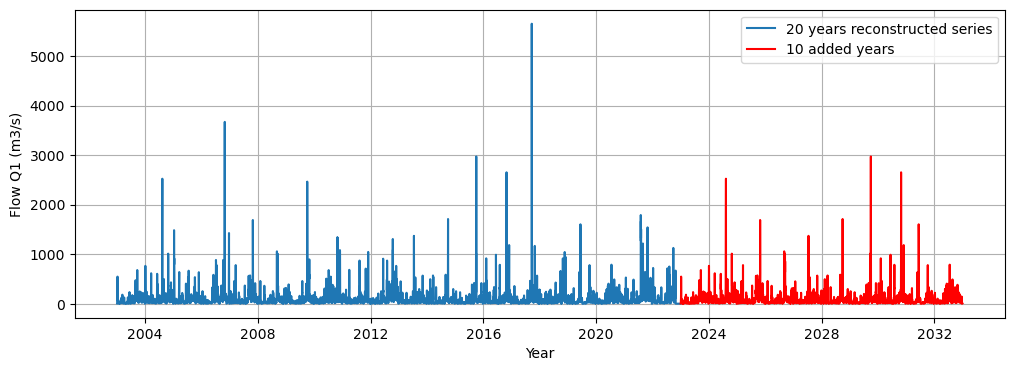

Autocorrélation des maxima annuels à 1 an de retard: 0.09259380705610262
Autocorrélation des maxima annuels à 2 an de retard: 0.0809913995334903


In [53]:
## 3)Sélection des années à ajouter
#Classer les années par type
percentiles = np.percentile(S1_max_annual, [33, 66])
low_threshold, high_threshold = percentiles

def classify_year(x):
    if x <= low_threshold:
        return 'faible'
    elif x <= high_threshold:
        return 'moyenne'
    else:
        return 'forte'

year_types = S1_max_annual.apply(classify_year)

np.random.seed(42)

def pick_years(years_list, n):
    return random.sample(list(years_list), n)

years_faible = pick_years(year_types[year_types == 'faible'].index, 3)
years_moyenne = pick_years(year_types[year_types == 'moyenne'].index, 4)
years_forte = pick_years(year_types[year_types == 'forte'].index, 3)

selected_years = list(years_faible) + list(years_moyenne) + list(years_forte)

random.shuffle(selected_years) #pour ne pas avoir de structure dans les donnée

print(f"Années sélectionnées : {selected_years}")

## 4) Construire la série avec les 10 années ajoutées

# Extraire toutes les journées correspondant aux années sélectionnées
copied_years = S1_full[S1_full['Year'].isin(selected_years)].copy()

# Modifier les dates
copied_years.drop(columns='Year', inplace=True)

last_date = S1_full.index.max()
new_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=len(copied_years), freq='D')
copied_years.index = new_dates

#Graphe
plt.figure(figsize=(12, 4))
plt.plot(S1_full.index, S1_full['Q1'], label='20 years reconstructed series')
plt.plot(copied_years.index, copied_years['Q1'], label='10 added years', color='red')
plt.xlabel('Year')
plt.ylabel('Flow Q1 (m3/s)')
#plt.title('Extension of S1 with swapping')
plt.legend()
plt.grid()
plt.savefig("data_P1\Q1_30y.pdf", format='pdf')
plt.show()



#Fusion
S1_extended = pd.concat([S1_full.drop(columns='Year'), copied_years])
S1_extended['Year'] = S1_extended.index.year

#verify autocorrelation
S1_extended_max_annual = S1_extended.groupby('Year')['Q1'].max()

#2) Corrélation temporelle des maximas annuels
autocorr1 = S1_extended_max_annual.autocorr(lag=1)  # Corrélation à 1 an de retard
print(f'Autocorrélation des maxima annuels à 1 an de retard: {autocorr1}')
autocorr2=S1_extended_max_annual.autocorr(lag=2)
print(f'Autocorrélation des maxima annuels à 2 an de retard: {autocorr2}')


<Figure size 800x600 with 0 Axes>

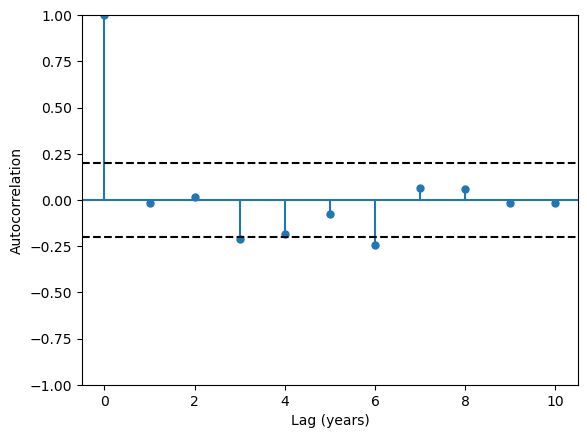

In [49]:
from statsmodels.graphics.tsaplots import plot_acf
plt.figure (figsize=(8, 6))
plot_acf(S1_extended_max_annual, alpha=None)
plt.axhline(y=0.2, color='black', linestyle='--')
plt.axhline(y=-0.2, color='black', linestyle='--')
plt.xlabel('Lag (years)')
plt.ylabel('Autocorrelation')
plt.title('')
plt.xlim(-0.5, 10.5)
#plt.yticks(np.arange(-1, 1.1, 0.2))
plt.savefig("data_P1\\autocorr2.pdf", format='pdf')

L'autocorrélation est bien faible.

## c) Flow duration curve and reference minimal instream flow

The $ Q_{347} $ is the flow dépassé 347 jours/an.

<>:19: SyntaxWarning: invalid escape sequence '\F'
<>:19: SyntaxWarning: invalid escape sequence '\F'
C:\Users\moeag\AppData\Local\Temp\ipykernel_19060\3085825178.py:19: SyntaxWarning: invalid escape sequence '\F'
  plt.savefig("data_P1\FDC.pdf", format='pdf')


Q347 (reference minimal instream flow) = 266.35 m³/s


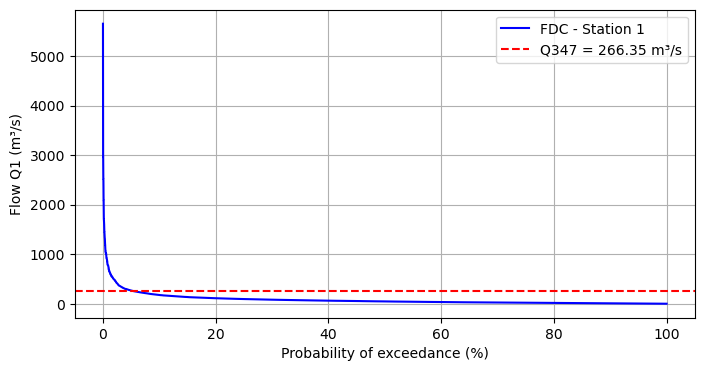

In [54]:
## Flow duration curve
Q_sorted = S1_extended['Q1'].sort_values(ascending=False).reset_index(drop=True)
N = len(Q_sorted) #nombre de jours
exceedance_probability = (np.arange(1, N+1)) / (N + 1)

## Calcul du Q347
Q347 = np.percentile(S1_extended['Q1'], 100 * (347/365.25))
print(f"Q347 (reference minimal instream flow) = {Q347:.2f} m³/s")

## Graphe
plt.figure(figsize=(8,4))
plt.plot(exceedance_probability*100, Q_sorted, label="FDC - Station 1", color='blue')
plt.xlabel('Probability of exceedance (%)')
plt.ylabel('Flow Q1 (m³/s)')
#plt.title('Flow Duration Curve - Station 1 (30 ans)')
plt.axhline(y=Q347, color='red', linestyle='--', label=f'Q347 = {Q347:.2f} m³/s')
plt.grid(True)
plt.legend()
plt.savefig("data_P1\FDC.pdf", format='pdf')
plt.show()

## d) Daily mean annual behaviour

In [56]:
S1_extended['Month'] = S1_extended.index.month
S1_extended['Day'] = S1_extended.index.day

S1_extended = S1_extended[~((S1_extended['Month'] == 2) & (S1_extended['Day'] == 29))] #enlever 29 février

print(S1_extended)

daily_mean_annual = S1_extended.groupby(['Month', 'Day'])['Q1'].mean().reset_index()

                    Q1  Year  Month  Day
2003-01-01    5.524043  2003      1    1
2003-01-02   16.062143  2003      1    2
2003-01-03   26.362046  2003      1    3
2003-01-04   63.154265  2003      1    4
2003-01-05  102.562171  2003      1    5
...                ...   ...    ...  ...
2032-12-28    3.628600  2032     12   28
2032-12-29    4.060576  2032     12   29
2032-12-30    3.455810  2032     12   30
2032-12-31    4.146972  2032     12   31
2033-01-01    6.047667  2033      1    1

[10951 rows x 4 columns]


<>:12: SyntaxWarning: invalid escape sequence '\Q'
<>:12: SyntaxWarning: invalid escape sequence '\Q'
C:\Users\moeag\AppData\Local\Temp\ipykernel_19060\2937925693.py:12: SyntaxWarning: invalid escape sequence '\Q'
  plt.savefig("data_P1\Q1_daily.pdf", format='pdf')
C:\Users\moeag\AppData\Local\Temp\ipykernel_19060\2937925693.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


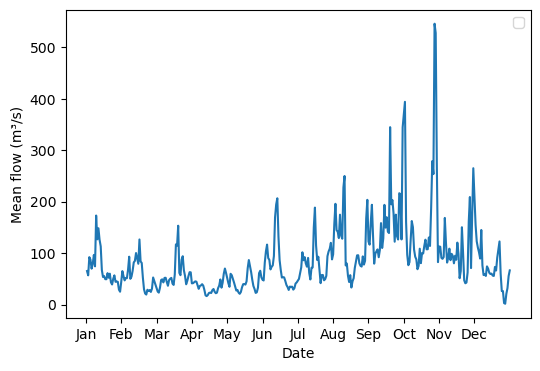

In [67]:
plt.figure(figsize=(6, 4))
plt.plot(daily_mean_annual['Month'] + daily_mean_annual['Day']/31, daily_mean_annual['Q1'])

plt.xlabel('Date')
plt.ylabel('Mean flow (m³/s)')
#plt.title('Average daily flow behaviour over a year (30 years dataset)')
#plt.grid(True)
plt.legend()

# Ajout des ticks pour les mois
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.savefig("data_P1\Q1_daily.pdf", format='pdf')
plt.show()

## e) Monthly mean annual time series

<>:12: SyntaxWarning: invalid escape sequence '\Q'
<>:12: SyntaxWarning: invalid escape sequence '\Q'
C:\Users\moeag\AppData\Local\Temp\ipykernel_19060\2336426302.py:12: SyntaxWarning: invalid escape sequence '\Q'
  plt.savefig("data_P1\Q1_monthly.pdf", format='pdf')
C:\Users\moeag\AppData\Local\Temp\ipykernel_19060\2336426302.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


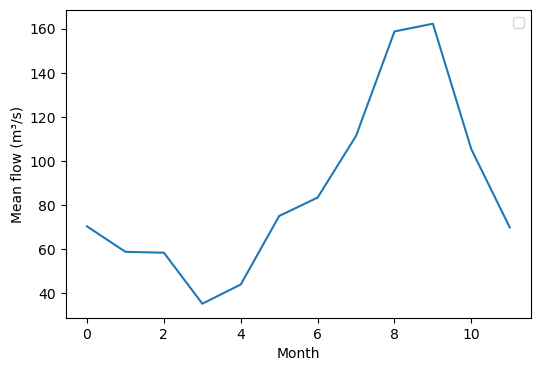

In [69]:
monthly_mean_annual=S1_extended.groupby(['Month'])['Q1'].mean().reset_index()
monthly_mean_annual

plt.figure(figsize=(6, 4))
plt.plot(monthly_mean_annual.index, monthly_mean_annual['Q1'])

plt.xlabel('Month')
plt.ylabel('Mean flow (m³/s)')
#plt.title('Average monthly mean flow')
#plt.grid(True)
plt.legend()
plt.savefig("data_P1\Q1_monthly.pdf", format='pdf')
plt.show()

## f) Sequence of dry periods and sequence of wet periods

In [75]:
#discriminant value for august-december
S1_aug_dec = S1_extended[S1_extended['Month'].isin([8, 9, 10, 11, 12])]

annual_mean_aug_dec = S1_aug_dec.groupby('Year')['Q1'].mean()
mean_annual_aug_dec_flow = annual_mean_aug_dec.mean()#accross the years= discriminant value
print(f'discriminant value: {mean_annual_aug_dec_flow}')

print(S1_extended.tail(15))

# #Classification in wet or dry
S1_extended = S1_extended[S1_extended['Year'] != 2033]
S1_extended['Period'] = S1_extended['Year'].map(lambda year: 'Wet' if annual_mean_aug_dec[year] > mean_annual_aug_dec_flow else 'Dry')

print(S1_extended.head(15))

# New series
S1_wet_years = S1_extended[S1_extended['Period'] == 'Wet']

S1_dry_years = S1_extended[S1_extended['Period'] == 'Dry']

print (S1_dry_years.head())
print (S1_wet_years.head())



discriminant value: 121.34739648232514
                    Q1  Year  Month  Day
2032-12-18   46.649560  2032     12   18
2032-12-19  146.990120  2032     12   19
2032-12-20   93.976181  2032     12   20
2032-12-21  126.272030  2032     12   21
2032-12-22   60.867858  2032     12   22
2032-12-23    0.790000  2032     12   23
2032-12-24    1.571000  2032     12   24
2032-12-25    0.762000  2032     12   25
2032-12-26    0.248000  2032     12   26
2032-12-27    0.132000  2032     12   27
2032-12-28    3.628600  2032     12   28
2032-12-29    4.060576  2032     12   29
2032-12-30    3.455810  2032     12   30
2032-12-31    4.146972  2032     12   31
2033-01-01    6.047667  2033      1    1
                    Q1  Year  Month  Day Period
2003-01-01    5.524043  2003      1    1    Dry
2003-01-02   16.062143  2003      1    2    Dry
2003-01-03   26.362046  2003      1    3    Dry
2003-01-04   63.154265  2003      1    4    Dry
2003-01-05  102.562171  2003      1    5    Dry
2003-01-06  202.1

C:\Users\moeag\AppData\Local\Temp\ipykernel_19060\2634986879.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  S1_extended['Period'] = S1_extended['Year'].map(lambda year: 'Wet' if annual_mean_aug_dec[year] > mean_annual_aug_dec_flow else 'Dry')


In [ ]:
# Exporter les datasets
from pathlib import Path
filepath=Path('data_P1/Monthly_mean_annual_flow')
monthly_mean_annual.to_csv(filepath)

S1_extended.to_csv('data_P1/S1_flow_30y.csv')
